# Calculate the physical features of FRBs

### Loading data

In [1]:
import pandas as pd
df=pd.read_csv(r"chimefrbcat1.csv")
df['previous_rp_name']=df['repeater_name']
for i in range(df.shape[0]):
    if df.loc[i,'repeater_name'] != '-9999':
        df.loc[i,'repeater_name']= 'repeater'
    else:
        df.loc[i,'repeater_name']= 'non-repeater'

df['scat_time']=df['scat_time'].str.replace(r'<','')
df['scat_time']=df['scat_time'].astype(float)
df['width_fitb']=df['width_fitb'].str.replace(r'<','')
df['width_fitb']=df['width_fitb'].astype(float)

df=df.drop(columns=['ra_notes','dec_notes','exp_up_notes','exp_low_notes','flux_notes','fluence_notes',
                    'ra_err','dec_err','exp_up_err','exp_low_err','dm_fitb_err','scat_time_err','flux_err','fluence_err','mjd_400','mjd_400_err','mjd_inf','mjd_inf_err','width_fitb_err','sp_idx_err','sp_run_err'])
print(len(df.columns))
df.head()

35


,tns_name,previous_name,repeater_name,ra,dec,gl,gb,exp_up,exp_low,bonsai_snr,...,sp_idx,sp_run,high_freq,low_freq,peak_freq,chi_sq,dof,flag_frac,excluded_flag,previous_rp_name
0,FRB20180725A,180725.J0613+67,non-repeater,93.42,67.07,147.29,21.29,30.0,-9999.0,19.2,...,38.20,-45.80,760.1,485.3,607.4,371857.954,371481,0.403,1,-9999
1,FRB20180727A,180727.J1311+26,non-repeater,197.72,26.42,24.76,85.60,10.4,-9999.0,10.4,...,3.80,-9.20,800.2,400.2,493.3,382969.318,381818,0.387,1,-9999
2,FRB20180729A,180729.J1316+55,non-repeater,199.40,55.58,115.26,61.16,21.0,-9999.0,32.0,...,16.46,-30.21,692.7,400.2,525.6,264732.041,186953,0.399,1,-9999
3,FRB20180729B,180729.J0558+56,non-repeater,89.93,56.50,156.90,15.68,21.0,-9999.0,12.4,...,14.50,-14.60,800.2,441.8,657.5,425139.488,421337,0.323,1,-9999
4,FRB20180730A,180730.J0353+87,non-repeater,57.39,87.19,125.11,25.11,270.0,214.0,69.5,...,4.27,-11.31,759.2,400.2,483.5,429165.844,417689,0.329,1,-9999


### Readshifts

$\Omega_b(baryon),\Omega_{c}(cold\;dark\;matter),\Omega_r(radiation\;energy)$

In [2]:
import astropy.units as u
import numpy as np
#Parameters
H=67.4#67.3 #km/s/Mpc
h=H/100
h2=h*h
O_b=0.0224/h2#0.0486
O_m=0.315#matter
O_k=0
O_L=1-O_m-O_k#dark energy

c=299792458 #m/s
pc_m=3.085677581491367e+16
cm=100
km=1000
M=1e6
m_p=1.67262192e-27#kg
G=6.67430e-11 #m^3/kg/s^2

$ \Omega_b\frac{3H_0 c}{8\pi G m_p}\frac{7}{8} $

In [3]:
alpha=3*7*H*c*O_b/8/8/np.pi/G/m_p*km/M/pc_m/cm/cm/cm/pc_m

In [4]:
from scipy import integrate

def f_IGM(z):
    return 0.83#(z>1.5)*0.9+(z<=1.5)*(0.053*z+0.82)

def I_IGM(z,m=O_m,la=O_L):
    return (1.+z)*f_IGM(z)/np.sqrt(m*(1.+z)**3+la)

def f_DM(z,a=alpha):
    Int=integrate.quad(I_IGM,0,z)[0]
    return 30.0+a*Int+70.0/(1.+z)

$DM-DM_{MW}=30+DM_{IGM}+\frac{70}{1+z}$

In [5]:
from scipy.optimize import fsolve
def f_z(DM_MW,n=8):
    ''' z1=0
    z2=3
    E=z2-z1
    error=1/pow(10,n)
    while E>=error/2:
        #print([f_DM(z1),f_DM(z2)])
        zt=(z1+z2)/2
        ft=f_DM(zt)-DM_MW
        
        if(ft<0):
            z1=zt
        elif(ft>0):
            z2=zt
        else:
            z=zt
            break
        
        E=z2-z1
        z=round((z1+z2)/2,n)
        #if(z==0):
        #    z=0.01 '''
    return fsolve(lambda z:f_DM(z)-DM_MW,0)[0]

In [6]:
z_min=H*10/c*1000
DM_MWs=df['dm_exc_ne2001'].values
redshift=np.zeros(len(DM_MWs))
for i,DM_MW in enumerate(DM_MWs):
    redshift[i]=f_z(DM_MW)
    if(redshift[i]<=z_min):
        #print(i)
        redshift[i]=z_min
df['redshift']=redshift

Load and replace special redshifts from sp_redshift.csv (Observation)

In [7]:
rs=pd.read_excel('sp_redshift.xlsx')
for i in range(len(rs['z'])):
    for j in range(len(df['tns_name'])):
        if((df.loc[j,'tns_name']==rs.loc[i,'FRB'])|(df.loc[j,'previous_name']==rs.loc[i,'FRB'])|(df.loc[j,'previous_rp_name']==rs.loc[i,'FRB'])):
            #print([df.loc[j,['tns_name','previous_name','previous_rp_name']],df.loc[j,'redshift'],rs.loc[i,'z']])
            df.loc[j,'redshift']=rs.loc[i,'z']

### Rest-frame frequency width

In [8]:
df['fre_width']=(df['high_freq']-df['low_freq'])*(1+df['redshift'])
df['fre_width_ob']=(df['high_freq']-df['low_freq'])

### Rest-frame width (ms)

$\frac{Width\,of\,sub-burst\,using\,fitburst}{1+z}$

In [9]:
#in_duration=df['bc_width'].values/(1+redshift)
in_duration=1000*df['width_fitb'].values/(1+redshift)
df['in_duration']=in_duration
#from s to ms
df.loc[:,'bc_width']=df['bc_width'].values*1000

# Energy

$d_L=(1+z)\frac{c}{H_0}\int_0^z\frac{dz'}{E(z')}$

$E(z)=\sqrt{\Omega_r(1+z)^4+\Omega_m(1+z)^3+\Omega_k(1+z)^2+\Omega_\Lambda}$

In [10]:
#DM=df['dm_exc_ne2001'].values
#d_L_DM=(DM/500)*(DM/1000+2.4) #Gpc e9
##d_L=2*df['redshift'].values*(2.4+df['redshift'].values)#Gpc

""" def E_(z,m=O_m,k=O_k,L=O_L):
    out=np.sqrt(m*pow(1+z,3)+k*pow(1+z,2)+L)
    return 1/out
d_H=c/H/1000/1000#Gpc
d_L_z=np.zeros(len(df['redshift'].values))
for i in range(len(df['redshift'].values)):
    t,e=integrate.quad(E_,0,redshift[i])
    d_L_z[i]=d_H*(1+redshift[i])*t """

" def E_(z,m=O_m,k=O_k,L=O_L):\n    out=np.sqrt(m*pow(1+z,3)+k*pow(1+z,2)+L)\n    return 1/out\nd_H=c/H/1000/1000#Gpc\nd_L_z=np.zeros(len(df['redshift'].values))\nfor i in range(len(df['redshift'].values)):\n    t,e=integrate.quad(E_,0,redshift[i])\n    d_L_z[i]=d_H*(1+redshift[i])*t "

astropy.cosmos distance

In [11]:
from astropy.cosmology import FlatLambdaCDM
cosmo=FlatLambdaCDM(H0=H*u.km/u.s/u.Mpc,Om0=O_m)#,Tcmb0=2.7255*u.K)
d_L_cos=cosmo.luminosity_distance(df['redshift'])#MPc

$E=\frac{4\pi d_L^2}{1+z}F_\nu \nu_c$

In [12]:
d_L=d_L_cos#cos with units *u.Mpc
#energy=4*np.pi*df['fluence']*400*0.01*pc_m*pc_m#Jy,400MHz,erg
energy=4*np.pi*df['fluence']*u.Jy*u.ms*df['peak_freq']*u.MHz#*0.01*pc_m*pc_m#Jy,400MHz,erg
energy=energy*d_L*d_L/(1+redshift)
for j in range(len(energy)):
    #energy[j]=d_L*d_L/(1+redshift[j])*energy[j]
    df.loc[j,'energy']=energy[j].to(u.erg).value
    #if(energy[j]==0):
    #    energy[j]=1
    #energy[j]=math.log(energy[j])

### Luminosity

$L=4\pi d_L^2S_{\nu,p}\nu_c$

In [13]:
import astropy.units as u
d_L=d_L_cos
Lum=4*np.pi*d_L*d_L*df['flux']*u.Jy*df['peak_freq']*u.MHz
for j in range(len(Lum)):
    df.loc[j,'luminosity']=Lum[j].to(u.erg/u.s).value
df.head()

,tns_name,previous_name,repeater_name,ra,dec,gl,gb,exp_up,exp_low,bonsai_snr,...,dof,flag_frac,excluded_flag,previous_rp_name,redshift,fre_width,fre_width_ob,in_duration,energy,luminosity
0,FRB20180725A,180725.J0613+67,non-repeater,93.42,67.07,147.29,21.29,30.0,-9999.0,19.2,...,371481,0.403,1,-9999,0.640740,450.875425,274.8,0.180406,2.827944e+40,1.923870e+43
1,FRB20180727A,180727.J1311+26,non-repeater,197.72,26.42,24.76,85.60,10.4,-9999.0,10.4,...,381818,0.387,1,-9999,0.614818,645.927163,400.0,0.860778,1.189571e+40,4.823143e+42
2,FRB20180729A,180729.J1316+55,non-repeater,199.40,55.58,115.26,61.16,21.0,-9999.0,32.0,...,186953,0.399,1,-9999,0.002248,293.157605,292.5,0.099776,1.070358e+36,7.383140e+38
3,FRB20180729B,180729.J0558+56,non-repeater,89.93,56.50,156.90,15.68,21.0,-9999.0,12.4,...,421337,0.323,1,-9999,0.157566,414.871625,358.4,0.271259,4.966122e+38,4.407270e+41
4,FRB20180730A,180730.J0353+87,non-repeater,57.39,87.19,125.11,25.11,270.0,214.0,69.5,...,417689,0.329,1,-9999,0.802405,647.063272,359.0,0.259653,2.335510e+41,8.107252e+43


### Brightness Temperature

$T_b=\frac{S_{\nu,p}d_L^2}{2\pi k_B(\nu \Delta t)^2}/(1+z)$   ,   $d_A=\frac{d_L}{(1+z)^2}$   ,   $\Delta \Omega=\pi(c\Delta t)^2/d_A^2$

In [14]:
import astropy.constants as c
d_L=d_L_cos
nu=df['peak_freq']*u.MHz
dt=df['bc_width']*u.s
TB=d_L**2*df['flux']*u.Jy/(1+redshift)/((nu*dt)**2)
for j in range(len(TB)):
    df.loc[j,'T_B']=(TB[j]/(2*np.pi*c.k_B)).to(u.K).value
df.head()

,tns_name,previous_name,repeater_name,ra,dec,gl,gb,exp_up,exp_low,bonsai_snr,...,flag_frac,excluded_flag,previous_rp_name,redshift,fre_width,fre_width_ob,in_duration,energy,luminosity,T_B
0,FRB20180725A,180725.J0613+67,non-repeater,93.42,67.07,147.29,21.29,30.0,-9999.0,19.2,...,0.403,1,-9999,0.640740,450.875425,274.8,0.180406,2.827944e+40,1.923870e+43,5.515622e+29
1,FRB20180727A,180727.J1311+26,non-repeater,197.72,26.42,24.76,85.60,10.4,-9999.0,10.4,...,0.387,1,-9999,0.614818,645.927163,400.0,0.860778,1.189571e+40,4.823143e+42,2.622746e+29
2,FRB20180729A,180729.J1316+55,non-repeater,199.40,55.58,115.26,61.16,21.0,-9999.0,32.0,...,0.399,1,-9999,0.002248,293.157605,292.5,0.099776,1.070358e+36,7.383140e+38,4.845901e+26
3,FRB20180729B,180729.J0558+56,non-repeater,89.93,56.50,156.90,15.68,21.0,-9999.0,12.4,...,0.323,1,-9999,0.157566,414.871625,358.4,0.271259,4.966122e+38,4.407270e+41,3.166148e+28
4,FRB20180730A,180730.J0353+87,non-repeater,57.39,87.19,125.11,25.11,270.0,214.0,69.5,...,0.329,1,-9999,0.802405,647.063272,359.0,0.259653,2.335510e+41,8.107252e+43,1.508095e+30


### Drop radio energy==0 index

In [15]:
print(len(df['tns_name']),np.sum(df['repeater_name']=='non-repeater'),np.sum(df['repeater_name']=='repeater'))
df=df.drop(df[df.energy==0].index)
df.reset_index(drop=True,inplace=True)
print(len(df['tns_name']),np.sum(df['repeater_name']=='non-repeater'),np.sum(df['repeater_name']=='repeater'))

600 506 94
594 500 94


### log10 columns

In [16]:
col1=df.columns
col=['repeater_name','dm_fitb', 'dm_exc_ne2001', 'bc_width', 'scat_time', 'flux', 'fluence','width_fitb','high_freq', 'low_freq', 'peak_freq','fre_width', 'redshift', 'in_duration','energy','luminosity','T_B']

In [17]:
logcol=['repeater_name']
for i in range(1,len(col)):
    logcol.append('log_'+col[i])
print(logcol)
logf=df[col]
logf.columns=logcol
for c in logcol[1:]:
    #print(c)
    for i in range(len(logf['log_redshift'])):
        if(logf.loc[i,c]==0):
            logf.loc[i,c]=0.01
        #print([c,i,logf.loc[i,c]])
        logf.loc[i,c]=np.log10(logf.loc[i,c])
logf.head()

['repeater_name', 'log_dm_fitb', 'log_dm_exc_ne2001', 'log_bc_width', 'log_scat_time', 'log_flux', 'log_fluence', 'log_width_fitb', 'log_high_freq', 'log_low_freq', 'log_peak_freq', 'log_fre_width', 'log_redshift', 'log_in_duration', 'log_energy', 'log_luminosity', 'log_T_B']


,repeater_name,log_dm_fitb,log_dm_exc_ne2001,log_bc_width,log_scat_time,log_flux,log_fluence,log_width_fitb,log_high_freq,log_low_freq,log_peak_freq,log_fre_width,log_redshift,log_in_duration,log_energy,log_luminosity,log_T_B
0,non-repeater,2.854797,2.809021,0.469822,-2.958607,0.230449,0.612784,-3.528708,2.880871,2.686010,2.783475,2.654057,-0.193318,-0.743748,40.451471,43.284176,29.741595
1,non-repeater,2.807626,2.793022,0.469822,-2.769551,-0.236572,0.363612,-2.856985,2.903199,2.602277,2.693111,2.810184,-0.211253,-0.065109,40.075391,42.683330,29.418756
2,non-repeater,2.039787,1.896526,-0.008774,-3.802995,1.068186,1.230449,-4.000000,2.840545,2.602277,2.720655,2.467101,-2.648161,-1.000975,36.029529,38.868241,26.685375
3,non-repeater,2.501365,2.348694,0.294466,-3.180456,-0.036212,0.079181,-3.503070,2.903199,2.645226,2.817896,2.617914,-0.802538,-0.566616,38.696017,41.644170,28.500531
4,non-repeater,2.928859,2.897462,0.691965,-2.683401,0.716003,1.431364,-3.329754,2.880356,2.602277,2.684396,2.810947,-0.095607,-0.585606,41.368382,43.908874,30.178429


### Save

In [18]:
df=df[col1]
df=pd.concat([df,logf.iloc[:,1:]],axis=1)
df.drop(columns=['gl','exp_up','exp_low','bonsai_snr','snr_fitb','flag_frac', 'excluded_flag'],inplace=True)
#df.drop(columns=[],inplace=True)
df.head()

,tns_name,previous_name,repeater_name,ra,dec,gb,bonsai_dm,low_ft_68,up_ft_68,low_ft_95,...,log_width_fitb,log_high_freq,log_low_freq,log_peak_freq,log_fre_width,log_redshift,log_in_duration,log_energy,log_luminosity,log_T_B
0,FRB20180725A,180725.J0613+67,non-repeater,93.42,67.07,21.29,716.6,0.0,2.7,0.0,...,-3.528708,2.880871,2.686010,2.783475,2.654057,-0.193318,-0.743748,40.451471,43.284176,29.741595
1,FRB20180727A,180727.J1311+26,non-repeater,197.72,26.42,85.60,642.1,0.0,1.9,0.0,...,-2.856985,2.903199,2.602277,2.693111,2.810184,-0.211253,-0.065109,40.075391,42.683330,29.418756
2,FRB20180729A,180729.J1316+55,non-repeater,199.40,55.58,61.16,108.4,0.0,4.6,0.0,...,-4.000000,2.840545,2.602277,2.720655,2.467101,-2.648161,-1.000975,36.029529,38.868241,26.685375
3,FRB20180729B,180729.J0558+56,non-repeater,89.93,56.50,15.68,318.6,0.0,0.9,0.0,...,-3.503070,2.903199,2.645226,2.817896,2.617914,-0.802538,-0.566616,38.696017,41.644170,28.500531
4,FRB20180730A,180730.J0353+87,non-repeater,57.39,87.19,25.11,849.2,3.3,2.3,6.1,...,-3.329754,2.880356,2.602277,2.684396,2.810947,-0.095607,-0.585606,41.368382,43.908874,30.178429


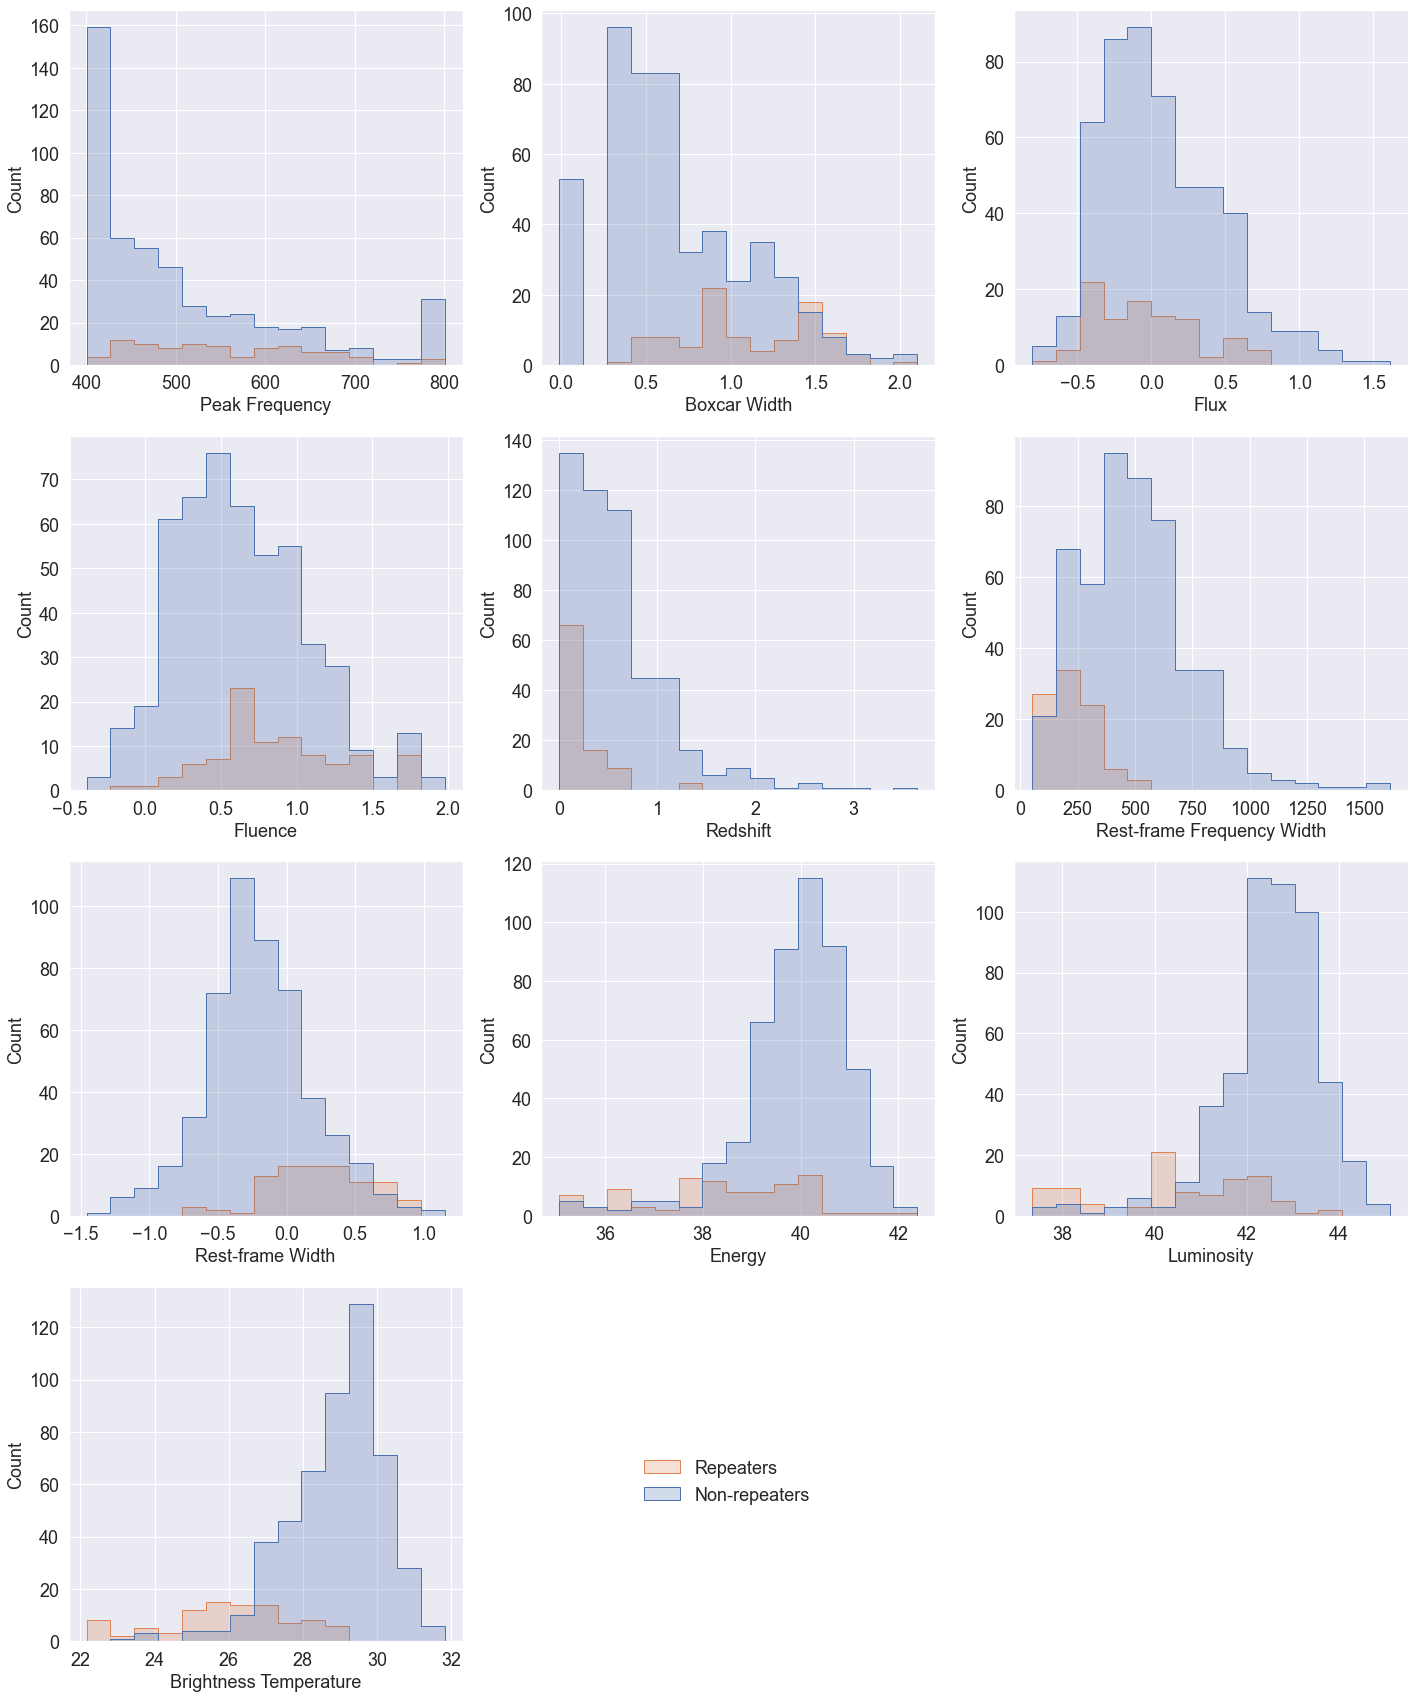

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
col=['peak_freq','log_bc_width','log_flux', 'log_fluence','redshift','fre_width','log_in_duration','log_energy', 'log_luminosity','log_T_B']
colx=['Peak Frequency','Boxcar Width','Flux','Fluence','Redshift','Rest-frame Frequency Width','Rest-frame Width','Energy','Luminosity','Brightness Temperature']
#colx=[r'$f_{peak}$',r'$\Delta t_{BC}$',r'$S_{\nu} $',r'$F_{\nu} $',r'$z$',r'$\Delta \nu$',r'$\Delta t_r$',r'$E$',r'L',r'$T_B$']
sns.set_theme(style='darkgrid')
p=24
figure = plt.figure(figsize=(p,1.25*p))
fs=18
for i in range(len(col)):
    plt.subplot(int((len(col)-1)/3)+1,3,i+1)
    sns.histplot(data=df,x=col[i],hue='repeater_name',bins=15,legend=False,element="step",kde=False)
    plt.xlabel(colx[i],fontsize=fs)
    plt.ylabel('Count',fontsize=fs)
    plt.tick_params(labelsize=fs)
figure.legend(labels=['Repeaters','Non-repeaters'],loc=[0.45,0.11],frameon=False,shadow=False,fontsize=fs)
plt.savefig('./fig/parameters.png',bbox_inches='tight',dpi=100,pad_inches=0.1)
plt.show()

# Analysis

In [20]:
""" from yellowbrick.features import Rank2D
X=df[col]
visualizer = Rank2D(algorithm="pearson")
visualizer.fit_transform(X)
plt.savefig('./fig/pearson.png')
visualizer.poof() """

' from yellowbrick.features import Rank2D\nX=df[col]\nvisualizer = Rank2D(algorithm="pearson")\nvisualizer.fit_transform(X)\nplt.savefig(\'./fig/pearson.png\')\nvisualizer.poof() '

In [21]:
""" df['repeater']=(df['repeater_name']=='repeater')
classes = ["non-repeater","repeater"]
X = df[col].values
y = df['repeater']
from yellowbrick.features import RadViz

visualizer = RadViz(classes=classes, features=col)
plt.figure(figsize=(10, 10))
visualizer.fit(X, y)      
visualizer.transform(X)
plt.savefig('./fig/RadViz.png')
visualizer.poof() """

' df[\'repeater\']=(df[\'repeater_name\']==\'repeater\')\nclasses = ["non-repeater","repeater"]\nX = df[col].values\ny = df[\'repeater\']\nfrom yellowbrick.features import RadViz\n\nvisualizer = RadViz(classes=classes, features=col)\nplt.figure(figsize=(10, 10))\nvisualizer.fit(X, y)      \nvisualizer.transform(X)\nplt.savefig(\'./fig/RadViz.png\')\nvisualizer.poof() '

In [22]:
""" from yellowbrick.features import ParallelCoordinates

visualizer = ParallelCoordinates(
    classes=classes, features=col,
    normalize='standard', 
    sample=0.4, 
    shuffle=True,
)
p=7
plt.figure(figsize=(2*p, p))
visualizer.fit_transform(X, y)
plt.savefig('./fig/parallel.png')
visualizer.show() """

" from yellowbrick.features import ParallelCoordinates\n\nvisualizer = ParallelCoordinates(\n    classes=classes, features=col,\n    normalize='standard', \n    sample=0.4, \n    shuffle=True,\n)\np=7\nplt.figure(figsize=(2*p, p))\nvisualizer.fit_transform(X, y)\nplt.savefig('./fig/parallel.png')\nvisualizer.show() "

In [23]:
df.to_csv(r"cul_cat1.csv")